In [1]:
import pandas as pd
import numpy as np

from h2o.grid.grid_search import H2OGridSearch

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

import h2o

try:
    h2o.cluster().shutdown()
except AttributeError:
    pass
    
h2o.init(nthreads = -1,
         max_mem_size = "4G")
#          max_mem_size = "24G")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_171"; OpenJDK Runtime Environment (build 1.8.0_171-8u171-b11-0ubuntu0.16.04.1-b11); OpenJDK 64-Bit Server VM (build 25.171-b11, mixed mode)
  Starting server from /usr/local/lib/python2.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpoGIUIx
  JVM stdout: /tmp/tmpoGIUIx/h2o_mourao_started_from_python.out
  JVM stderr: /tmp/tmpoGIUIx/h2o_mourao_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Sao_Paulo
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.4
H2O cluster version age:,2 months and 24 days
H2O cluster name:,H2O_from_python_mourao_jamnjl
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [2]:
# seed for reproducibility
my_seed = 1980

In [3]:
# read data
my_path = '../'

train = pd.read_csv(my_path + 'data/c2_e6_2_train.csv')
test = pd.read_csv(my_path + 'data/c2_e6_1_test.csv')

In [4]:
# remove unused attributes

train.drop('base_guess', axis=1, inplace=True)
test.drop(['cd_pss', 'nm_mun_uor', 'sg_uf_uor', 'target', 'base_guess'], axis=1, inplace=True)

In [5]:
# transform data to H2O format.
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
# changing label to factor informs to H2O that the problem is solved by classification.
train_h2o['label'] = train_h2o['label'].asfactor()
test_h2o['label'] = test_h2o['label'].asfactor()

In [7]:
# list of features
features = train.columns.tolist()
features.remove('label')

In [33]:
# Logistic Regression (LR)

# lambda value | alpha value       | Result
# -------------+-------------------+-------------------------------------
# lambda = 0   | alpha = any value | No regularization. alpha is ignored.
# lambda > 0   | alpha = 0         | Ridge Regression
# lambda > 0   | alpha = 1         | LASSO
# lambda > 0   | 0 < alpha < 1     | Elastic Net Penalty



hyper_parameters = { 'alpha': [0, 0.1, 0.5, 0.7, 1.0] }

lr_grid = H2OGridSearch(H2OGeneralizedLinearEstimator(family='binomial', 
                                                      seed=my_seed,
                                                      fold_assignment='Modulo',
                                                      lambda_search=True,
                                                      nfolds=5), 
                         grid_id='lr_grid',
                         hyper_params=hyper_parameters)

lr_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
lr_gridperf1 = lr_grid.get_grid(sort_by='F1', decreasing=True)
print(lr_gridperf1)

# Grab the top LR model, chosen by validation F1
best_lr1 = lr_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_lr_perf1 = best_lr1.model_performance(test_h2o)
print(best_lr_perf1)

glm Grid Build progress: |████████████████████████████████████████████████| 100%
     alpha        model_ids                  f1
0    [0.1]  lr_grid_model_1  0.8347987616099071
1    [0.0]  lr_grid_model_0  0.8343077497201143
2    [0.5]  lr_grid_model_2  0.8337945028592512
3    [0.7]  lr_grid_model_3  0.8331144875883199
4    [1.0]  lr_grid_model_4  0.8319325124833298


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.107862551509
RMSE: 0.328424346706
LogLoss: 0.375572969033
Null degrees of freedom: 12476
Residual degrees of freedom: 12427
Null deviance: 17296.7947437
Residual deviance: 9372.04786924
AIC: 9472.04786924
AUC: 0.897141556985
Gini: 0.79428311397
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.844612541977: 


,0,1,Error,Rate
0,11599.0,298.0,0.025,(298.0/11897.0)
1,276.0,304.0,0.4759,(276.0/580.0)
Total,11875.0,602.0,0.046,(574.0/12477.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.8446125,0.5143824,43.0
max f2,0.7574453,0.5522247,64.0
max f0point5,0.9560257,0.5692220,14.0
max accuracy,0.9874275,0.9624910,5.0
max precision,0.9997644,0.864,0.0
max recall,0.0352667,1.0,383.0
max specificity,0.9997644,0.9985711,0.0
max absolute_mcc,0.9079308,0.4939335,27.0
max min_per_class_accuracy,0.4225921,0.8206897,167.0
max mean_per_class_accuracy,0.4281826,0.8217716,165.0


Gains/Lift Table: Avg response rate:  4,65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100184,0.9988865,18.7585241,18.7585241,0.872,0.872,0.1879310,0.1879310,1775.8524138,1775.8524138
,2,0.0200369,0.9668401,11.7025655,15.2305448,0.544,0.708,0.1172414,0.3051724,1070.2565517,1423.0544828
,3,0.0300553,0.9213672,9.4653103,13.3088,0.44,0.6186667,0.0948276,0.4,846.5310345,1230.88
,4,0.0400737,0.8767107,7.0559586,11.7455897,0.328,0.546,0.0706897,0.4706897,605.5958621,1074.5589655
,5,0.0500120,0.8331605,5.5515017,10.5147132,0.2580645,0.4887821,0.0551724,0.5258621,455.1501669,951.4713196
,6,0.1000240,0.6552013,2.9303299,6.7225216,0.1362179,0.3125,0.1465517,0.6724138,193.0329907,572.2521552
,7,0.1500361,0.5323348,1.4479277,4.9643236,0.0673077,0.2307692,0.0724138,0.7448276,44.7927719,396.4323607
,8,0.2000481,0.4359109,1.3100298,4.0507502,0.0608974,0.1883013,0.0655172,0.8103448,31.0029841,305.0750166
,9,0.2999920,0.3039130,0.7245444,2.9426073,0.0336808,0.1367887,0.0724138,0.8827586,-27.5455576,194.2607350
,10,0.4000160,0.2235344,0.3447447,2.2930116,0.0160256,0.1065919,0.0344828,0.9172414,-65.5255305,129.3011559


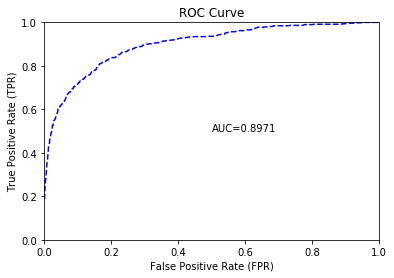

In [34]:
best_lr_perf1.plot()

In [61]:
best_lr1.parms['lambda']['actual_value']

[2.347159615932647,
 2.138644424696164,
 1.9486531483571814,
 1.7755401733702547,
 1.6178060779618149,
 1.4740846448560774,
 1.3431310277545856,
 1.2238109690730978,
 1.1150909755450116,
 1.0160293665971023,
 0.9257681179628905,
 0.8435254298869167,
 0.7685889555492659,
 0.7003096310581943,
 0.6380960535692057,
 0.5814093588365343,
 0.5297585538288361,
 0.48269626398243803,
 0.439814858256888,
 0.4007429184298893,
 0.36514202205034263,
 0.33270381118497294,
 0.3031473215694273,
 0.2762165490302279,
 0.2516782320990916,
 0.2293198316136821,
 0.20894768980506248,
 0.19038535292674505,
 0.17347204289675314,
 0.15806126471478996,
 0.14401953759262795,
 0.1312252388073772,
 0.11956755026364306,
 0.1089454986401983,
 0.09926708080737937,
 0.09044846693999077,
 0.0824132744234627,
 0.07509190626418444,
 0.06842094827364026,
 0.062342619805045386,
 0.05680427328502524,
 0.051757938205521055,
 0.04715990562619774,
 0.0429703495885127,
 0.03915298216231531,
 0.035674739137155805,
 0.032505493635

In [ ]:
# Random Forest (RF)

hyper_par    = { 
                 'ntrees' :  [50, 100],
                 'mtries' : [1, -1],
#                  'col_sample_rate_change_per_level' : [1, 2], # https://0xdata.atlassian.net/browse/PUBDEV-5334    
                 'max_depth' : [2, 20],
                 'sample_rate' : [0.6320000291, 1.],  # outro aumento absurdo
                 'col_sample_rate_per_tree' : [0.5, 1.], # documentacao errada tb
                 'min_split_improvement' : [1e-4, 1e-5] 
               }

rf_grid = H2OGridSearch(H2ORandomForestEstimator(seed=my_seed, 
                                                 nfolds=5, 
                                                 fold_assignment='Modulo'), 
                         grid_id='rf_grid',
                         hyper_params=hyper_par)

rf_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
rf_gridperf1 = rf_grid.get_grid(sort_by='F1', decreasing=True)
print(rf_gridperf1)

# Grab the top RF model, chosen by validation F1
best_rf = rf_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_rf_perf1 = best_rf.model_performance(test_h2o)
print(best_rf_perf1)

In [ ]:
# Random Forest (RF) - Refinement 1

hyper_par    = { 
                 'ntrees' :  [75, 100],
                 'mtries' : [-1],
                 'max_depth' : [20],
                 'sample_rate' : [1],  
                 'col_sample_rate_per_tree' : [.5], 
                 'min_split_improvement' : [5e-4, 1e-5] 
               }

rf_grid = H2OGridSearch(H2ORandomForestEstimator(seed=my_seed, 
                                                 nfolds=5, 
                                                 fold_assignment='Modulo'), 
                         grid_id='rf_grid_1',
                         hyper_params=hyper_par)

rf_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
rf_gridperf1 = rf_grid.get_grid(sort_by='F1', decreasing=True)
print(rf_gridperf1)

# Grab the top RF model, chosen by validation F1
best_rf = rf_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_rf_perf1 = best_rf.model_performance(test_h2o)
print(best_rf_perf1)

In [ ]:
# Random Forest (RF) - Refinement 2

hyper_par    = { 
                 'ntrees' :  [25, 100],
                 'mtries' : [-1],
                 'max_depth' : [20],
                 'sample_rate' : [1],  
                 'col_sample_rate_per_tree' : [.5], 
                 'min_split_improvement' : [7e-4, 1e-5] 
               }

rf_grid = H2OGridSearch(H2ORandomForestEstimator(seed=my_seed, 
                                                 nfolds=5, 
                                                 fold_assignment='Modulo'), 
                         grid_id='rf_grid_2',
                         hyper_params=hyper_par)

rf_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
rf_gridperf1 = rf_grid.get_grid(sort_by='F1', decreasing=True)
print(rf_gridperf1)

# Grab the top RF model, chosen by validation F1
best_rf = rf_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_rf_perf1 = best_rf.model_performance(test_h2o)
print(best_rf_perf1)

In [ ]:
# Random Forest (RF) - Refinement 3

hyper_par    = { 
                 'ntrees' :  [100, 150],
                 'mtries' : [-1],
                 'max_depth' : [20],
                 'sample_rate' : [1],  
                 'col_sample_rate_per_tree' : [.5], 
                 'min_split_improvement' : [8e-4, 1e-5] 
               }

rf_grid = H2OGridSearch(H2ORandomForestEstimator(seed=my_seed, 
                                                 nfolds=5, 
                                                 fold_assignment='Modulo'), 
                         grid_id='rf_grid_3',
                         hyper_params=hyper_par)

rf_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
rf_gridperf1 = rf_grid.get_grid(sort_by='F1', decreasing=True)
print(rf_gridperf1)

# Grab the top RF model, chosen by validation F1
best_rf = rf_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_rf_perf1 = best_rf.model_performance(test_h2o)
print(best_rf_perf1)

In [8]:
# Random Forest (RF) - Final Model

hyper_par    = { 
                 'ntrees' :  [100],
                 'mtries' : [-1],
                 'max_depth' : [20],
                 'sample_rate' : [1],  
                 'col_sample_rate_per_tree' : [.5], 
                 'min_split_improvement' : [1e-5] 
               }

rf_grid = H2OGridSearch(H2ORandomForestEstimator(seed=my_seed, 
                                                 nfolds=5, 
                                                 fold_assignment='Modulo'), 
                         grid_id='rf_grid_4',
                         hyper_params=hyper_par)

rf_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
rf_gridperf1 = rf_grid.get_grid(sort_by='F1', decreasing=True)
print(rf_gridperf1)

# Grab the top RF model, chosen by validation F1
best_rf = rf_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_rf_perf1 = best_rf.model_performance(test_h2o)
print(best_rf_perf1)

drf Grid Build progress: |████████████████████████████████████████████████| 100%
    col_sample_rate_per_tree max_depth min_split_improvement mtries ntrees  \
0                        0.5        20                1.0E-5     -1    100   

  sample_rate          model_ids                  f1  
0         1.0  rf_grid_4_model_0  0.9995580529073805  


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.0297861558489
RMSE: 0.172586661851
LogLoss: 0.119465735913
Mean Per-Class Error: 0.140603759858
AUC: 0.928242703898
Gini: 0.856485407796
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.262218615992: 


,0,1,Error,Rate
0,11609.0,288.0,0.0242,(288.0/11897.0)
1,265.0,315.0,0.4569,(265.0/580.0)
Total,11874.0,603.0,0.0443,(553.0/12477.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2622186,0.5325444,143.0
max f2,0.1882609,0.6052311,178.0
max f0point5,0.3946670,0.5903548,92.0
max accuracy,0.4073942,0.9631322,88.0
max precision,0.97,1.0,0.0
max recall,0.0001019,1.0,399.0
max specificity,0.97,1.0,0.0
max absolute_mcc,0.2127157,0.5132221,165.0
max min_per_class_accuracy,0.0949240,0.8568966,245.0
max mean_per_class_accuracy,0.0982892,0.8593962,242.0


Gains/Lift Table: Avg response rate:  4,65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100184,0.6374441,18.9306207,18.9306207,0.88,0.88,0.1896552,0.1896552,1793.0620690,1793.0620690
,2,0.0200369,0.4437804,12.3909517,15.6607862,0.576,0.728,0.1241379,0.3137931,1139.0951724,1466.0786207
,3,0.0300553,0.3533212,9.6374069,13.6529931,0.448,0.6346667,0.0965517,0.4103448,863.7406897,1265.2993103
,4,0.0400737,0.2970869,7.7443448,12.1758310,0.36,0.566,0.0775862,0.4879310,674.4344828,1117.5831034
,5,0.0500120,0.2551347,6.4189238,11.0318302,0.2983871,0.5128205,0.0637931,0.5517241,541.8923804,1003.1830239
,6,0.1000240,0.1554884,3.5853448,7.3085875,0.1666667,0.3397436,0.1793103,0.7310345,258.5344828,630.8587533
,7,0.1500361,0.1083511,2.0684682,5.5618811,0.0961538,0.2585470,0.1034483,0.8344828,106.8468170,456.1881079
,8,0.2000481,0.0833297,0.8618617,4.3868762,0.0400641,0.2039263,0.0431034,0.8775862,-13.8138263,338.6876243
,9,0.2999920,0.0554018,0.5175317,3.0977839,0.0240577,0.1440021,0.0517241,0.9293103,-48.2468269,209.7783909
,10,0.4000160,0.0394951,0.3102702,2.4007659,0.0144231,0.1116009,0.0310345,0.9603448,-68.9729775,140.0765861


In [ ]:
best_rf_perf1.plot()

In [10]:
# Gradient Boosting Machine (GBM)

# GBM hyperparameters
hyper_par    = { 
                 'ntrees' :  [50, 100],
                 'learn_rate' : [0.5, 1.],
                 'max_depth' : [2, 20],
                 'sample_rate' : [0.6320000291, 1.],
                 'col_sample_rate_per_tree' : [0.5, 1.],
                 'min_split_improvement' : [1e-4, 1e-5] 
               }

# Train and validate a cartesian grid of GBMs
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator(seed=my_seed, 
                                                            nfolds=5,
                                                            fold_assignment='Modulo'),
                          grid_id='gbm_grid',
                          hyper_params=hyper_par)
gbm_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
gbm_gridperf1 = gbm_grid.get_grid(sort_by='F1', decreasing=True)
print(gbm_gridperf1)

# Grab the top GBM model, chosen by validation F1
best_gbm = gbm_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf1 = best_gbm.model_performance(test_h2o)
print(best_gbm_perf1)


gbm Grid Build progress: |████████████████████████████████████████████████| 100%
      col_sample_rate_per_tree learn_rate max_depth min_split_improvement  \
0                          1.0        0.5        20                1.0E-5   
1                          0.5        0.5        20                1.0E-5   
2                          0.5        1.0        20                1.0E-5   
3                          0.5        1.0        20                1.0E-5   
4                          0.5        1.0        20                1.0E-4   
5                          1.0        0.5        20                1.0E-4   
6                          0.5        1.0        20                1.0E-4   
7                          1.0        0.5        20                1.0E-5   
8                          0.5        0.5        20                1.0E-5   
9                          0.5        0.5        20                1.0E-5   
10                         0.5        0.5        20                1.0E-

,0,1,Error,Rate
0,11724.0,173.0,0.0145,(173.0/11897.0)
1,297.0,283.0,0.5121,(297.0/580.0)
Total,12021.0,456.0,0.0377,(470.0/12477.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0143677,0.5463320,271.0
max f2,0.0000218,0.6002495,394.0
max f0point5,0.3728591,0.6086519,169.0
max accuracy,0.9969515,0.9640939,34.0
max precision,0.9999994,0.8692308,0.0
max recall,0.0000000,1.0,399.0
max specificity,0.9999994,0.9985711,0.0
max absolute_mcc,0.0565449,0.5322465,231.0
max min_per_class_accuracy,0.0000020,0.7293103,398.0
max mean_per_class_accuracy,0.0000020,0.8310753,398.0


Gains/Lift Table: Avg response rate:  4,65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100184,0.9999957,18.5864276,18.5864276,0.864,0.864,0.1862069,0.1862069,1758.6427586,1758.6427586
,2,0.0200369,0.9728571,13.5956276,16.0910276,0.632,0.748,0.1362069,0.3224138,1259.5627586,1509.1027586
,3,0.0300553,0.2014661,10.6699862,14.2840138,0.496,0.664,0.1068966,0.4293103,966.9986207,1328.4013793
,4,0.0400737,0.0047453,7.5722483,12.6060724,0.352,0.586,0.0758621,0.5051724,657.2248276,1160.6072414
,5,0.0500120,0.0004688,4.1636263,10.9284068,0.1935484,0.5080128,0.0413793,0.5465517,316.3626251,992.8406830
,6,0.1000240,0.0000012,3.7921916,7.3602992,0.1762821,0.3421474,0.1896552,0.7362069,279.2191645,636.0299237
,7,0.1500361,0.0000001,1.9650448,5.5618811,0.0913462,0.2585470,0.0982759,0.8344828,96.5044761,456.1881079
,8,0.2000481,0.0000000,0.7929128,4.3696390,0.0368590,0.203125,0.0396552,0.8741379,-20.7087202,336.9639009
,9,0.2999920,0.0000000,0.5175317,3.0862893,0.0240577,0.1434678,0.0517241,0.9258621,-48.2468269,208.6289349
,10,0.4000160,0.0000000,0.2240841,2.3705947,0.0104167,0.1101984,0.0224138,0.9482759,-77.5915948,137.0594657


In [11]:
# Gradient Boosting Machine (GBM) - Refinement 1

# GBM hyperparameters
hyper_par    = { 
                 'ntrees' :  [5, 50, 100, 150],
                 'learn_rate' : [0.5, 1.],
                 'max_depth' : [20],
                 'sample_rate' : [1.],
                 'col_sample_rate_per_tree' : [0.5, 1.],
                 'min_split_improvement' : [1e-5] 
               }
                
                 

# Train and validate a cartesian grid of GBMs
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator(seed=my_seed, 
                                                            nfolds=5,
                                                            fold_assignment='Modulo'),
                          grid_id='gbm_grid_1',
                          hyper_params=hyper_par)

gbm_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
gbm_gridperf1 = gbm_grid.get_grid(sort_by='F1', decreasing=True)
print(gbm_gridperf1)

# Grab the top GBM model, chosen by validation F1
best_gbm = gbm_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf1 = best_gbm.model_performance(test_h2o)
print(best_gbm_perf1)


gbm Grid Build progress: |████████████████████████████████████████████████| 100%
     col_sample_rate_per_tree learn_rate max_depth min_split_improvement  \
0                         1.0        0.5        20                1.0E-5   
1                         0.5        1.0        20                1.0E-5   
2                         0.5        0.5        20                1.0E-5   
3                         0.5        0.5        20                1.0E-5   
4                         0.5        1.0        20                1.0E-5   
5                         0.5        1.0        20                1.0E-5   
6                         1.0        0.5        20                1.0E-5   
7                         1.0        0.5        20                1.0E-5   
8                         0.5        0.5        20                1.0E-5   
9                         1.0        1.0        20                1.0E-5   
10                        1.0        1.0        20                1.0E-5   
11     

,0,1,Error,Rate
0,11724.0,173.0,0.0145,(173.0/11897.0)
1,297.0,283.0,0.5121,(297.0/580.0)
Total,12021.0,456.0,0.0377,(470.0/12477.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0143677,0.5463320,271.0
max f2,0.0000218,0.6002495,394.0
max f0point5,0.3728591,0.6086519,169.0
max accuracy,0.9969515,0.9640939,34.0
max precision,0.9999994,0.8692308,0.0
max recall,0.0000000,1.0,399.0
max specificity,0.9999994,0.9985711,0.0
max absolute_mcc,0.0565449,0.5322465,231.0
max min_per_class_accuracy,0.0000020,0.7293103,398.0
max mean_per_class_accuracy,0.0000020,0.8310753,398.0


Gains/Lift Table: Avg response rate:  4,65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100184,0.9999957,18.5864276,18.5864276,0.864,0.864,0.1862069,0.1862069,1758.6427586,1758.6427586
,2,0.0200369,0.9728571,13.5956276,16.0910276,0.632,0.748,0.1362069,0.3224138,1259.5627586,1509.1027586
,3,0.0300553,0.2014661,10.6699862,14.2840138,0.496,0.664,0.1068966,0.4293103,966.9986207,1328.4013793
,4,0.0400737,0.0047453,7.5722483,12.6060724,0.352,0.586,0.0758621,0.5051724,657.2248276,1160.6072414
,5,0.0500120,0.0004688,4.1636263,10.9284068,0.1935484,0.5080128,0.0413793,0.5465517,316.3626251,992.8406830
,6,0.1000240,0.0000012,3.7921916,7.3602992,0.1762821,0.3421474,0.1896552,0.7362069,279.2191645,636.0299237
,7,0.1500361,0.0000001,1.9650448,5.5618811,0.0913462,0.2585470,0.0982759,0.8344828,96.5044761,456.1881079
,8,0.2000481,0.0000000,0.7929128,4.3696390,0.0368590,0.203125,0.0396552,0.8741379,-20.7087202,336.9639009
,9,0.2999920,0.0000000,0.5175317,3.0862893,0.0240577,0.1434678,0.0517241,0.9258621,-48.2468269,208.6289349
,10,0.4000160,0.0000000,0.2240841,2.3705947,0.0104167,0.1101984,0.0224138,0.9482759,-77.5915948,137.0594657


In [12]:
# Gradient Boosting Machine (GBM) - Refinement 2

# GBM hyperparameters
hyper_par    = { 
                 'ntrees' :  [50],
                 'learn_rate' : [0.7, 1.],
                 'max_depth' : [20],
                 'sample_rate' : [1.],
                 'col_sample_rate_per_tree' : [0.7, 1.],
                 'min_split_improvement' : [1e-5] 
               }
                
                 

# Train and validate a cartesian grid of GBMs
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator(seed=my_seed, 
                                                            nfolds=5,
                                                            fold_assignment='Modulo'),
                          grid_id='gbm_grid_2',
                          hyper_params=hyper_par)

gbm_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
gbm_gridperf1 = gbm_grid.get_grid(sort_by='F1', decreasing=True)
print(gbm_gridperf1)

# Grab the top GBM model, chosen by validation F1
best_gbm = gbm_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf1 = best_gbm.model_performance(test_h2o)
print(best_gbm_perf1)


gbm Grid Build progress: |████████████████████████████████████████████████| 100%
    col_sample_rate_per_tree learn_rate max_depth min_split_improvement  \
0                        0.7        0.7        20                1.0E-5   
1                        0.7        1.0        20                1.0E-5   
2                        1.0        1.0        20                1.0E-5   
3                        1.0        0.7        20                1.0E-5   

  ntrees sample_rate           model_ids                  f1  
0     50         1.0  gbm_grid_2_model_0  0.9995265002051832  
1     50         1.0  gbm_grid_2_model_2  0.9994949494949494  
2     50         1.0  gbm_grid_2_model_3  0.9991795519091196  
3     50         1.0  gbm_grid_2_model_1  0.9991795519091196  


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.0353512396727
RMSE: 0.188019253463
LogLoss: 0.503581030709
Mean Per-Class Error: 0.187013750207
AUC: 0.820554877642
Gini: 0.641109755285
Confusion Matrix (Act/Pred

,0,1,Error,Rate
0,11581.0,316.0,0.0266,(316.0/11897.0)
1,240.0,340.0,0.4138,(240.0/580.0)
Total,11821.0,656.0,0.0446,(556.0/12477.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0000176,0.5501618,388.0
max f2,0.0000006,0.6001234,398.0
max f0point5,0.7618122,0.5967933,123.0
max accuracy,0.8735708,0.9636130,109.0
max precision,0.9999978,0.8549618,1.0
max recall,0.0000000,1.0,399.0
max specificity,0.9999999,0.9984030,0.0
max absolute_mcc,0.0000176,0.5279184,388.0
max min_per_class_accuracy,0.0000006,0.6706897,398.0
max mean_per_class_accuracy,0.0000006,0.8129862,398.0


Gains/Lift Table: Avg response rate:  4,65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100184,0.9999989,18.5864276,18.5864276,0.864,0.864,0.1862069,0.1862069,1758.6427586,1758.6427586
,2,0.0200369,0.9073908,13.5956276,16.0910276,0.632,0.748,0.1362069,0.3224138,1259.5627586,1509.1027586
,3,0.0300553,0.0243313,10.3257931,14.1692828,0.48,0.6586667,0.1034483,0.4258621,932.5793103,1316.9282759
,4,0.0400737,0.0005159,6.8838621,12.3479276,0.32,0.574,0.0689655,0.4948276,588.3862069,1134.7927586
,5,0.0500120,0.0000251,7.4598304,11.3765749,0.3467742,0.5288462,0.0741379,0.5689655,645.9830367,1037.6574934
,6,0.1000240,0.0000000,3.5163959,7.4464854,0.1634615,0.3461538,0.1758621,0.7448276,251.6395889,644.6485411
,7,0.1500361,0.0000000,1.7581979,5.5503896,0.0817308,0.2580128,0.0879310,0.8327586,75.8197944,455.0389589
,8,0.2000481,0.0000000,0.8618617,4.3782576,0.0400641,0.2035256,0.0431034,0.8758621,-13.8138263,337.8257626
,9,0.2999920,0.0000000,0.6900423,3.1495094,0.0320770,0.1464066,0.0689655,0.9448276,-30.9957692,214.9509429
,10,0.4000160,0.0000000,0.1723723,2.4050760,0.0080128,0.1118012,0.0172414,0.9620690,-82.7627653,140.5076033


In [13]:
# Gradient Boosting Machine (GBM) - Refinement 3

# GBM hyperparameters
hyper_par    = { 
                 'ntrees' :  [50],
                 'learn_rate' : [.7, .9],
                 'max_depth' : [20],
                 'sample_rate' : [1.],
                 'col_sample_rate_per_tree' : [0.7],
                 'min_split_improvement' : [1e-5] 
               }
                
                 

# Train and validate a cartesian grid of GBMs
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator(seed=my_seed, 
                                                            nfolds=5,
                                                            fold_assignment='Modulo'),
                          grid_id='gbm_grid_3',
                          hyper_params=hyper_par)

gbm_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
gbm_gridperf1 = gbm_grid.get_grid(sort_by='F1', decreasing=True)
print(gbm_gridperf1)

# Grab the top GBM model, chosen by validation F1
best_gbm = gbm_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf1 = best_gbm.model_performance(test_h2o)
print(best_gbm_perf1)


gbm Grid Build progress: |████████████████████████████████████████████████| 100%
    col_sample_rate_per_tree learn_rate max_depth min_split_improvement  \
0                        0.7        0.9        20                1.0E-5   
1                        0.7        0.7        20                1.0E-5   

  ntrees sample_rate           model_ids                  f1  
0     50         1.0  gbm_grid_3_model_1  0.9996211642884202  
1     50         1.0  gbm_grid_3_model_0  0.9995265002051832  


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.0356139622167
RMSE: 0.188716618814
LogLoss: 0.631079580147
Mean Per-Class Error: 0.199800224919
AUC: 0.805697394011
Gini: 0.611394788022
Confusion Matrix (Act/Pred) for max f1 @ threshold = 5.47646633027e-07: 


,0,1,Error,Rate
0,11583.0,314.0,0.0264,(314.0/11897.0)
1,237.0,343.0,0.4086,(237.0/580.0)
Total,11820.0,657.0,0.0442,(551.0/12477.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0000005,0.5545675,393.0
max f2,0.0000001,0.5922953,398.0
max f0point5,0.1893813,0.5983146,159.0
max accuracy,0.9608633,0.9637733,99.0
max precision,1.0000000,0.8677686,0.0
max recall,0.0000000,1.0,399.0
max specificity,1.0000000,0.9986551,0.0
max absolute_mcc,0.0000005,0.5325729,393.0
max min_per_class_accuracy,0.0000001,0.6362069,398.0
max mean_per_class_accuracy,0.0000001,0.8001998,398.0


Gains/Lift Table: Avg response rate:  4,65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100184,0.9999997,18.4143310,18.4143310,0.856,0.856,0.1844828,0.1844828,1741.4331035,1741.4331035
,2,0.0200369,0.9155730,13.5956276,16.0049793,0.632,0.744,0.1362069,0.3206897,1259.5627586,1500.4979310
,3,0.0300553,0.0042370,10.1536966,14.0545517,0.472,0.6533333,0.1017241,0.4224138,915.3696552,1305.4551724
,4,0.0400737,0.0000405,7.9164414,12.5200241,0.368,0.582,0.0793103,0.5017241,691.6441379,1152.0024138
,5,0.0500120,0.0000010,6.7658927,11.3765749,0.3145161,0.5288462,0.0672414,0.5689655,576.5892659,1037.6574934
,6,0.1000240,0.0000000,3.4474469,7.4120109,0.1602564,0.3445513,0.1724138,0.7413793,244.7446950,641.2010942
,7,0.1500361,0.0000000,1.7926724,5.5388981,0.0833333,0.2574786,0.0896552,0.8310345,79.2672414,453.8898099
,8,0.2000481,0.0000000,0.8963362,4.3782576,0.0416667,0.2035256,0.0448276,0.8758621,-10.3663793,337.8257626
,9,0.2999920,0.0000000,0.4657786,3.0747948,0.0216520,0.1429335,0.0465517,0.9224138,-53.4221442,207.4794789
,10,0.4000160,0.0000000,0.2585585,2.3705947,0.0120192,0.1101984,0.0258621,0.9482759,-74.1441479,137.0594657


In [14]:
# Gradient Boosting Machine (GBM) - Refinement 4

# GBM hyperparameters
hyper_par    = { 
                 'ntrees' :  [50],
                 'learn_rate' : [.8, .9],
                 'max_depth' : [20],
                 'sample_rate' : [1.],
                 'col_sample_rate_per_tree' : [0.7],
                 'min_split_improvement' : [1e-5] 
               }
                
                 

# Train and validate a cartesian grid of GBMs
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator(seed=my_seed, 
                                                            nfolds=5,
                                                            fold_assignment='Modulo'),
                          grid_id='gbm_grid_4',
                          hyper_params=hyper_par)

gbm_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
gbm_gridperf1 = gbm_grid.get_grid(sort_by='F1', decreasing=True)
print(gbm_gridperf1)

# Grab the top GBM model, chosen by validation F1
best_gbm = gbm_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf1 = best_gbm.model_performance(test_h2o)
print(best_gbm_perf1)


gbm Grid Build progress: |████████████████████████████████████████████████| 100%
    col_sample_rate_per_tree learn_rate max_depth min_split_improvement  \
0                        0.7        0.9        20                1.0E-5   
1                        0.7        0.8        20                1.0E-5   

  ntrees sample_rate           model_ids                  f1  
0     50         1.0  gbm_grid_4_model_1  0.9996211642884202  
1     50         1.0  gbm_grid_4_model_0  0.9994318540496181  


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.0356139622167
RMSE: 0.188716618814
LogLoss: 0.631079580147
Mean Per-Class Error: 0.199800224919
AUC: 0.805697394011
Gini: 0.611394788022
Confusion Matrix (Act/Pred) for max f1 @ threshold = 5.47646633027e-07: 


,0,1,Error,Rate
0,11583.0,314.0,0.0264,(314.0/11897.0)
1,237.0,343.0,0.4086,(237.0/580.0)
Total,11820.0,657.0,0.0442,(551.0/12477.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0000005,0.5545675,393.0
max f2,0.0000001,0.5922953,398.0
max f0point5,0.1893813,0.5983146,159.0
max accuracy,0.9608633,0.9637733,99.0
max precision,1.0000000,0.8677686,0.0
max recall,0.0000000,1.0,399.0
max specificity,1.0000000,0.9986551,0.0
max absolute_mcc,0.0000005,0.5325729,393.0
max min_per_class_accuracy,0.0000001,0.6362069,398.0
max mean_per_class_accuracy,0.0000001,0.8001998,398.0


Gains/Lift Table: Avg response rate:  4,65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100184,0.9999997,18.4143310,18.4143310,0.856,0.856,0.1844828,0.1844828,1741.4331035,1741.4331035
,2,0.0200369,0.9155730,13.5956276,16.0049793,0.632,0.744,0.1362069,0.3206897,1259.5627586,1500.4979310
,3,0.0300553,0.0042370,10.1536966,14.0545517,0.472,0.6533333,0.1017241,0.4224138,915.3696552,1305.4551724
,4,0.0400737,0.0000405,7.9164414,12.5200241,0.368,0.582,0.0793103,0.5017241,691.6441379,1152.0024138
,5,0.0500120,0.0000010,6.7658927,11.3765749,0.3145161,0.5288462,0.0672414,0.5689655,576.5892659,1037.6574934
,6,0.1000240,0.0000000,3.4474469,7.4120109,0.1602564,0.3445513,0.1724138,0.7413793,244.7446950,641.2010942
,7,0.1500361,0.0000000,1.7926724,5.5388981,0.0833333,0.2574786,0.0896552,0.8310345,79.2672414,453.8898099
,8,0.2000481,0.0000000,0.8963362,4.3782576,0.0416667,0.2035256,0.0448276,0.8758621,-10.3663793,337.8257626
,9,0.2999920,0.0000000,0.4657786,3.0747948,0.0216520,0.1429335,0.0465517,0.9224138,-53.4221442,207.4794789
,10,0.4000160,0.0000000,0.2585585,2.3705947,0.0120192,0.1101984,0.0258621,0.9482759,-74.1441479,137.0594657


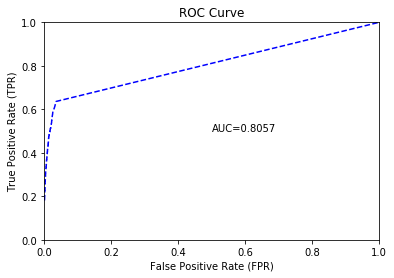

In [15]:
best_gbm_perf1.plot()

In [16]:
# Deep Learning (DL)

hyper_parameters = {'activation': ['tanh', 'tanh_with_dropout', 'rectifier', 
                                   'rectifier_with_dropout', 'maxout', 'maxout_with_dropout'],
                    'epochs' : [5, 10],
                    'hidden' : [[10, 10], [10, 10, 10]],
                    'input_dropout_ratio' : [.1, .2],
                    'l1' : [.0, .5],
                    'l2' : [.0, .5]
                   }

dl_grid = H2OGridSearch(H2ODeepLearningEstimator(seed=my_seed, 
                                                 nfolds=5, 
                                                 fold_assignment='Modulo'), 
                        grid_id='dl_grid',
                        hyper_params=hyper_parameters)

dl_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
dl_gridperf1 = dl_grid.get_grid(sort_by='F1', decreasing=True)
print(dl_gridperf1)

# Grab the top DL model, chosen by validation F1
best_dl = dl_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_dl_perf1 = best_dl.model_performance(test_h2o)
print(best_dl_perf1)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
                  activation              epochs        hidden  \
0                       Tanh   5.197171810615108      [10, 10]   
1                     Maxout  10.400028398673907  [10, 10, 10]   
2       RectifierWithDropout   5.197171810615108      [10, 10]   
3                     Maxout   5.197171810615108      [10, 10]   
4       RectifierWithDropout   5.197171810615108  [10, 10, 10]   
5                  Rectifier   5.197171810615108  [10, 10, 10]   
6                       Tanh  10.400028398673907  [10, 10, 10]   
7                     Maxout  10.400028398673907      [10, 10]   
8          MaxoutWithDropout   5.197171810615108      [10, 10]   
9                  Rectifier   5.197171810615108  [10, 10, 10]   
10      RectifierWithDropout  10.400028398673907      [10, 10]   
11                      Tanh   5.197171810615108  [10, 10, 10]   
12                    Maxout  10.400028398673907      [10, 10

,0,1,Error,Rate
0,11658.0,239.0,0.0201,(239.0/11897.0)
1,304.0,276.0,0.5241,(304.0/580.0)
Total,11962.0,515.0,0.0435,(543.0/12477.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.7674567,0.5041096,61.0
max f2,0.3480278,0.5578627,173.0
max f0point5,0.9039933,0.5791284,28.0
max accuracy,0.9076071,0.9625711,27.0
max precision,0.9917445,0.9,0.0
max recall,0.0075731,1.0,393.0
max specificity,0.9917445,0.9999159,0.0
max absolute_mcc,0.7674567,0.4823650,61.0
max min_per_class_accuracy,0.1341745,0.8227284,263.0
max mean_per_class_accuracy,0.1243864,0.8273888,268.0


Gains/Lift Table: Avg response rate:  4,65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100184,0.9513590,16.6933655,16.6933655,0.776,0.776,0.1672414,0.1672414,1569.3365517,1569.3365517
,2,0.0200369,0.9162353,13.5956276,15.1444966,0.632,0.704,0.1362069,0.3034483,1259.5627586,1414.4496552
,3,0.0300553,0.8516258,9.4653103,13.2514345,0.44,0.616,0.0948276,0.3982759,846.5310345,1225.1434483
,4,0.0400737,0.7773101,6.7117655,11.6165172,0.312,0.54,0.0672414,0.4655172,571.1765517,1061.6517241
,5,0.0500120,0.6867062,3.9901418,10.1010196,0.1854839,0.4695513,0.0396552,0.5051724,299.0141824,910.1019562
,6,0.1000240,0.3593097,3.5508704,6.8259450,0.1650641,0.3173077,0.1775862,0.6827586,255.0870358,582.5944960
,7,0.1500361,0.2154114,1.7926724,5.1481874,0.0833333,0.2393162,0.0896552,0.7724138,79.2672414,414.8187445
,8,0.2000481,0.1410548,0.8963362,4.0852246,0.0416667,0.1899038,0.0448276,0.8172414,-10.3663793,308.5224635
,9,0.2999920,0.0731870,0.7590465,2.9770910,0.0352847,0.1383917,0.0758621,0.8931034,-24.0953461,197.7091030
,10,0.4000160,0.0453684,0.3964564,2.3318031,0.0184295,0.1083951,0.0396552,0.9327586,-60.3543601,133.1803108


In [17]:
# Deep Learning (DL) - Refinement 1

hyper_parameters = {'activation': ['tanh', 'maxout'],
                    'epochs' : [5, 10],
                    'hidden' : [[10, 10], [20, 20]],
                    'input_dropout_ratio' : [.1],
                    'l1' : [.0, 1e-2],
                    'l2' : [.0, 1e-2]
                   }

dl_grid = H2OGridSearch(H2ODeepLearningEstimator(seed=my_seed, 
                                                 nfolds=5, 
                                                 fold_assignment='Modulo'), 
                        grid_id='dl_grid_1',
                        hyper_params=hyper_parameters)

dl_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
dl_gridperf1 = dl_grid.get_grid(sort_by='F1', decreasing=True)
print(dl_gridperf1)

# Grab the top DL model, chosen by validation F1
best_dl = dl_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_dl_perf1 = best_dl.model_performance(test_h2o)
print(best_dl_perf1)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
     activation              epochs    hidden input_dropout_ratio    l1    l2  \
0        Maxout  10.400028398673907  [20, 20]                 0.1   0.0   0.0   
1          Tanh  10.400028398673907  [20, 20]                 0.1   0.0   0.0   
2          Tanh  10.400028398673907  [10, 10]                 0.1   0.0   0.0   
3          Tanh  10.400028398673907  [20, 20]                 0.1   0.0  0.01   
4        Maxout   5.197171810615108  [10, 10]                 0.1  0.01   0.0   
5        Maxout   5.197171810615108  [20, 20]                 0.1   0.0   0.0   
6        Maxout  10.400028398673907  [10, 10]                 0.1  0.01   0.0   
7          Tanh   5.197171810615108  [10, 10]                 0.1  0.01   0.0   
8        Maxout  10.400028398673907  [20, 20]                 0.1  0.01  0.01   
9        Maxout  10.400028398673907  [10, 10]                 0.1   0.0   0.0   
10       Maxout  10.40002839

,0,1,Error,Rate
0,11591.0,306.0,0.0257,(306.0/11897.0)
1,289.0,291.0,0.4983,(289.0/580.0)
Total,11880.0,597.0,0.0477,(595.0/12477.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.9958604,0.4944775,3.0
max f2,0.9789641,0.5583531,13.0
max f0point5,0.9998737,0.5421053,0.0
max accuracy,0.9998737,0.9600866,0.0
max precision,0.9998737,0.6242424,0.0
max recall,0.0037693,1.0,394.0
max specificity,0.9998737,0.9895772,0.0
max absolute_mcc,0.9974264,0.4696756,2.0
max min_per_class_accuracy,0.8524545,0.8275862,66.0
max mean_per_class_accuracy,0.8279650,0.8307736,75.0


Gains/Lift Table: Avg response rate:  4,65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100184,0.9999968,18.2422345,18.2422345,0.848,0.848,0.1827586,0.1827586,1724.2234483,1724.2234483
,2,0.0200369,0.9998050,10.8420828,14.5421586,0.504,0.676,0.1086207,0.2913793,984.2082759,1354.2158621
,3,0.0300553,0.9988860,9.1211172,12.7351448,0.424,0.592,0.0913793,0.3827586,812.1117241,1173.5144828
,4,0.0400737,0.9971544,7.5722483,11.4444207,0.352,0.532,0.0758621,0.4586207,657.2248276,1044.4420690
,5,0.0500120,0.9946912,4.6840795,10.1010196,0.2177419,0.4695513,0.0465517,0.5051724,368.4079533,910.1019562
,6,0.1000240,0.9675925,3.5853448,6.8431822,0.1666667,0.3181090,0.1793103,0.6844828,258.5344828,584.3182195
,7,0.1500361,0.9179515,1.7237235,5.1366960,0.0801282,0.2387821,0.0862069,0.7706897,72.3723475,413.6695955
,8,0.2000481,0.8534602,1.0342341,4.1110805,0.0480769,0.1911058,0.0517241,0.8224138,3.4234085,311.1080487
,9,0.2999920,0.6789228,0.6900423,2.9713437,0.0320770,0.1381245,0.0689655,0.8913793,-30.9957692,197.1343750
,10,0.4000160,0.5009849,0.4481681,2.3404235,0.0208333,0.1087958,0.0448276,0.9362069,-55.1831897,134.0423452


In [18]:
# Deep Learning (DL) - Refinement 2

hyper_parameters = {'activation': ['tanh', 'maxout'],
                    'epochs' : [10],
                    'hidden' : [[20, 20], [30, 30]],
                    'input_dropout_ratio' : [.1],
                    'l1' : [.0],
                    'l2' : [.0]
                   }

dl_grid = H2OGridSearch(H2ODeepLearningEstimator(seed=my_seed, 
                                                 nfolds=5, 
                                                 fold_assignment='Modulo'), 
                        grid_id='dl_grid_2',
                        hyper_params=hyper_parameters)

dl_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
dl_gridperf1 = dl_grid.get_grid(sort_by='F1', decreasing=True)
print(dl_gridperf1)

# Grab the top DL model, chosen by validation F1
best_dl = dl_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_dl_perf1 = best_dl.model_performance(test_h2o)
print(best_dl_perf1)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
    activation              epochs    hidden input_dropout_ratio   l1   l2  \
0       Maxout  10.400028398673907  [30, 30]                 0.1  0.0  0.0   
1         Tanh  10.400028398673907  [30, 30]                 0.1  0.0  0.0   
2       Maxout  10.400028398673907  [20, 20]                 0.1  0.0  0.0   
3         Tanh  10.400028398673907  [20, 20]                 0.1  0.0  0.0   

           model_ids                  f1  
0  dl_grid_2_model_3  0.8606990725355729  
1  dl_grid_2_model_2  0.8604917981952928  
2  dl_grid_2_model_1  0.8238240028617422  
3  dl_grid_2_model_0  0.8168299783990233  


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.037159680504
RMSE: 0.192768463458
LogLoss: 0.159378928779
Mean Per-Class Error: 0.188456304545
AUC: 0.886346818816
Gini: 0.772693637631
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.532853189568: 


,0,1,Error,Rate
0,11696.0,201.0,0.0169,(201.0/11897.0)
1,348.0,232.0,0.6,(348.0/580.0)
Total,12044.0,433.0,0.044,(549.0/12477.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5328532,0.4580454,119.0
max f2,0.0924643,0.5240913,278.0
max f0point5,0.9041665,0.5336676,32.0
max accuracy,0.9041665,0.9610483,32.0
max precision,0.9999477,0.8846154,0.0
max recall,0.0000169,1.0,399.0
max specificity,0.9999477,0.9994957,0.0
max absolute_mcc,0.5328532,0.4406778,119.0
max min_per_class_accuracy,0.0171236,0.8034483,350.0
max mean_per_class_accuracy,0.0295977,0.8115437,331.0


Gains/Lift Table: Avg response rate:  4,65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100184,0.9834693,17.3817517,17.3817517,0.808,0.808,0.1741379,0.1741379,1638.1751724,1638.1751724
,2,0.0200369,0.8379521,10.6699862,14.0258690,0.496,0.652,0.1068966,0.2810345,966.9986207,1302.5868965
,3,0.0300553,0.6239138,7.9164414,11.9893931,0.368,0.5573333,0.0793103,0.3603448,691.6441379,1098.9393103
,4,0.0400737,0.4466363,6.0233793,10.4978897,0.28,0.488,0.0603448,0.4206897,502.3379310,949.7889655
,5,0.0500120,0.3204781,5.2045328,9.4460046,0.2419355,0.4391026,0.0517241,0.4724138,420.4532814,844.6004642
,6,0.1000240,0.0883737,3.4129725,6.4294886,0.1586538,0.2988782,0.1706897,0.6431034,241.2972480,542.9488561
,7,0.1500361,0.0400655,1.8960958,4.9183576,0.0881410,0.2286325,0.0948276,0.7379310,89.6095822,391.8357648
,8,0.2000481,0.0210125,0.9652851,3.9300895,0.0448718,0.1826923,0.0482759,0.7862069,-3.4714854,293.0089523
,9,0.2999920,0.0075118,0.7072934,2.8563982,0.0328789,0.1327812,0.0706897,0.8568966,-29.2706634,185.6398150
,10,0.4000160,0.0032609,0.4309309,2.2499098,0.0200321,0.1045883,0.0431034,0.9,-56.9069131,124.9909838


In [19]:
# Deep Learning (DL) - Refinement 3

hyper_parameters = {'activation': ['tanh', 'maxout'],
                    'epochs' : [5],
                    'hidden' : [[30, 30], [50, 50]],
                    'input_dropout_ratio' : [.1],
                    'l1' : [.0],
                    'l2' : [.0]
                   }

dl_grid = H2OGridSearch(H2ODeepLearningEstimator(seed=my_seed, 
                                                 nfolds=5, 
                                                 fold_assignment='Modulo'), 
                        grid_id='dl_grid_3',
                        hyper_params=hyper_parameters)

dl_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
dl_gridperf1 = dl_grid.get_grid(sort_by='F1', decreasing=True)
print(dl_gridperf1)

# Grab the top DL model, chosen by validation F1
best_dl = dl_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_dl_perf1 = best_dl.model_performance(test_h2o)
print(best_dl_perf1)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
    activation             epochs    hidden input_dropout_ratio   l1   l2  \
0         Tanh  5.197171810615108  [30, 30]                 0.1  0.0  0.0   
1       Maxout  5.197171810615108  [30, 30]                 0.1  0.0  0.0   
2       Maxout  5.197171810615108  [50, 50]                 0.1  0.0  0.0   
3         Tanh  5.197171810615108  [50, 50]                 0.1  0.0  0.0   

           model_ids                  f1  
0  dl_grid_3_model_0  0.8567309425121644  
1  dl_grid_3_model_1  0.8564667334122144  
2  dl_grid_3_model_3  0.8538049555647107  
3  dl_grid_3_model_2  0.8134379981352823  


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.229073907109
RMSE: 0.478616659875
LogLoss: 0.711572438437
Mean Per-Class Error: 0.185894879323
AUC: 0.892766504451
Gini: 0.785533008901
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.964041076497: 


,0,1,Error,Rate
0,11560.0,337.0,0.0283,(337.0/11897.0)
1,308.0,272.0,0.531,(308.0/580.0)
Total,11868.0,609.0,0.0517,(645.0/12477.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.9640411,0.4575273,16.0
max f2,0.9061748,0.5192630,38.0
max f0point5,0.9792652,0.4746241,9.0
max accuracy,0.9897625,0.9572013,4.0
max precision,0.9949828,0.7375,1.0
max recall,0.0265075,1.0,384.0
max specificity,0.9970250,0.9989913,0.0
max absolute_mcc,0.9640411,0.4305447,16.0
max min_per_class_accuracy,0.7210509,0.8091956,103.0
max mean_per_class_accuracy,0.7001502,0.8141051,111.0


Gains/Lift Table: Avg response rate:  4,65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100184,0.9922666,14.4561103,14.4561103,0.672,0.672,0.1448276,0.1448276,1345.6110345,1345.6110345
,2,0.0200369,0.9858732,10.8420828,12.6490966,0.504,0.588,0.1086207,0.2534483,984.2082759,1164.9096552
,3,0.0300553,0.9789595,8.4327310,11.2436414,0.392,0.5226667,0.0844828,0.3379310,743.2731034,1024.3641379
,4,0.0400737,0.9715516,6.7117655,10.1106724,0.312,0.47,0.0672414,0.4051724,571.1765517,911.0672414
,5,0.0500120,0.9615102,6.7658927,9.4460046,0.3145161,0.4391026,0.0672414,0.4724138,576.5892659,844.6004642
,6,0.1000240,0.9062885,3.2406001,6.3433024,0.1506410,0.2948718,0.1620690,0.6344828,224.0600133,534.3302387
,7,0.1500361,0.8387757,1.7926724,4.8264257,0.0833333,0.2243590,0.0896552,0.7241379,79.2672414,382.6425729
,8,0.2000481,0.7516000,1.2066064,3.9214709,0.0560897,0.1822917,0.0603448,0.7844828,20.6606432,292.1470905
,9,0.2999920,0.5879874,0.8970550,2.9138709,0.0417001,0.1354528,0.0896552,0.8741379,-10.2944999,191.3870950
,10,0.4000160,0.4437532,0.4826426,2.3059421,0.0224359,0.1071929,0.0482759,0.9224138,-51.7357427,130.5942075


In [22]:
# Deep Learning (DL) - Final

hyper_parameters = {'activation': ['tanh'],
                    'epochs' : [5],
                    'hidden' : [[10, 10]],
                    'input_dropout_ratio' : [.1],
                    'l1' : [.0],
                    'l2' : [.0]
                   }

dl_grid = H2OGridSearch(H2ODeepLearningEstimator(seed=my_seed, 
                                                 nfolds=5, 
                                                 fold_assignment='Modulo'), 
                        grid_id='dl_grid_4',
                        hyper_params=hyper_parameters)

dl_grid.train(x=features, 
               y='label', 
               training_frame=train_h2o)

# Get the grid results, sorted by validation F1-Measure
dl_gridperf1 = dl_grid.get_grid(sort_by='F1', decreasing=True)
print(dl_gridperf1)

# Grab the top DL model, chosen by validation F1
best_dl = dl_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_dl_perf1 = best_dl.model_performance(test_h2o)
print(best_dl_perf1)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
    activation             epochs    hidden input_dropout_ratio   l1   l2  \
0         Tanh  5.197171810615108  [10, 10]                 0.1  0.0  0.0   

           model_ids                  f1  
0  dl_grid_4_model_0  0.8348618317847232  


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.0320765761761
RMSE: 0.179099347224
LogLoss: 0.122198992032
Mean Per-Class Error: 0.174675591934
AUC: 0.905747319666
Gini: 0.811494639332
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.408306444204: 


,0,1,Error,Rate
0,11719.0,178.0,0.015,(178.0/11897.0)
1,327.0,253.0,0.5638,(327.0/580.0)
Total,12046.0,431.0,0.0405,(505.0/12477.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4083064,0.5004946,136.0
max f2,0.0798509,0.5504331,274.0
max f0point5,0.6587980,0.5679012,77.0
max accuracy,0.6634303,0.9621704,76.0
max precision,0.9654107,1.0,0.0
max recall,0.0025218,1.0,395.0
max specificity,0.9654107,1.0,0.0
max absolute_mcc,0.4083064,0.4856323,136.0
max min_per_class_accuracy,0.0257868,0.8241379,332.0
max mean_per_class_accuracy,0.0257868,0.8253244,332.0


Gains/Lift Table: Avg response rate:  4,65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100184,0.7788110,15.8328828,15.8328828,0.736,0.736,0.1586207,0.1586207,1483.2882759,1483.2882759
,2,0.0200369,0.6693131,14.6282069,15.2305448,0.68,0.708,0.1465517,0.3051724,1362.8206897,1423.0544828
,3,0.0300553,0.4842197,9.2932138,13.2514345,0.432,0.616,0.0931034,0.3982759,829.3213793,1225.1434483
,4,0.0400737,0.3355950,5.8512828,11.4013966,0.272,0.53,0.0586207,0.4568966,485.1282759,1040.1396552
,5,0.0500120,0.2532910,4.3371107,9.9975962,0.2016129,0.4647436,0.0431034,0.5,333.7110679,899.7596154
,6,0.1000240,0.0797433,3.5508704,6.7742333,0.1650641,0.3149038,0.1775862,0.6775862,255.0870358,577.4233256
,7,0.1500361,0.0414254,1.5858256,5.0447640,0.0737179,0.2345085,0.0793103,0.7568966,58.5825597,404.4764036
,8,0.2000481,0.0262756,1.1721320,4.0766060,0.0544872,0.1895032,0.0586207,0.8155172,17.2131963,307.6606018
,9,0.2999920,0.0142183,0.7245444,2.9598492,0.0336808,0.1375902,0.0724138,0.8879310,-27.5455576,195.9849190
,10,0.4000160,0.0093926,0.4998798,2.3447336,0.0232372,0.1089962,0.05,0.9379310,-50.0120192,134.4733624


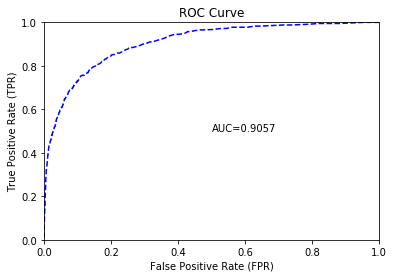

In [23]:
best_dl_perf1.plot()

In [9]:
h2o.cluster().shutdown()

H2O session _sid_8255 closed.
